# `0.` IMPORTING REQUIRED LIBs

In [1]:
# base libariries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# statistics
import statsmodels.api as sm

# preprocessing libariries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# splitting helper
from sklearn.model_selection import train_test_split

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# draw tree
from sklearn import tree

# evaluation metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# warnings
import warnings
warnings.filterwarnings("ignore")

C:\anaconda3\envs\linalgenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\anaconda3\envs\linalgenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# `1.` HELPER FUNCTIONS

In [2]:
# function to get the updated numerical columns
def get_numeric(features_df):
    return [c for c, dt in zip(features_df.dtypes.index, features_df.dtypes.values) if np.issubdtype(dt, np.number)]

#### `1.0` Handling duplicates

In [3]:
def handle_duplicates(features_df, dup_threshold):
    # data shape
    observations_num = features_df.shape[0]

    cols_to_be_dropped = []
    for c in features_df.columns:
        if (features_df[c].value_counts()/observations_num > dup_threshold).sum():
            cols_to_be_dropped.append(c)
            
    return cols_to_be_dropped

In [4]:
def drop_duplicates(features_df, cols_to_be_dropped):
    features_df.drop(columns=cols_to_be_dropped, inplace=True)

    return None

#### `1.1` Handling outliers

In [5]:
def handle_outliers(features_df, out_threshold):
    numeric = get_numeric(features_df) 
    Q1 = np.quantile(features_df[numeric], q=0.25, method='midpoint', axis=0)
    Q3 = np.quantile(features_df[numeric], q=0.75, method='midpoint', axis=0)

    IQR = Q3 - Q1
    upper_bound = Q3 + out_threshold * IQR
    lower_bound = Q1 - out_threshold * IQR

    return lower_bound, upper_bound

In [6]:
def outliers_clamping(features_df, lower_bound, upper_bound):
    numeric = get_numeric(features_df)
    num_of_features = numeric.__len__()
    
    for i in range(num_of_features):
        before = features_df[numeric[i]]
        features_df[numeric[i]] = np.where(features_df[numeric[i]] <= upper_bound[i], features_df[numeric[i]], upper_bound[i])
        features_df[numeric[i]] = np.where(features_df[numeric[i]] >= lower_bound[i], features_df[numeric[i]], lower_bound[i])
        after = features_df[numeric[i]]
        print(f'shape = {features_df.shape[0]}, total matched {(before == after).sum()}')

#### `1.2` Handling skewness

In [7]:
def skewness(features_df):
    # data shape
    observations_num = features_df.shape[0]
    
    numeric = get_numeric(features_df)

    numenator = np.sum(np.power(features_df[numeric] - features_df[numeric].mean(axis=0), 3), axis=0) * observations_num
    denumenator = np.power(features_df[numeric].std(axis=0), 3) * (observations_num - 1) * (observations_num - 2)
    sk_coeff = (numenator/denumenator).reset_index().rename(columns={0: 'sk_coef'})
    
    print(f"*SK_coeff: {sk_coeff}")
    final = list(set(sk_coeff[sk_coeff['sk_coef']>=1]['index']).union(set(sk_coeff[sk_coeff['sk_coef']<=-1]['index'])))

    return final

In [8]:
def handle_skewness(features_df, cols_to_be_transformed):
    features_df[cols_to_be_transformed] = np.log(np.abs(features_df[cols_to_be_transformed]) + 1)
        
    return None

#### `1.3` Checking normal distribution

In [9]:
def normality_test(features_df, shapiro_alpha):
    sample_df = features_df.sample(replace=False, n=2000)
    numeric = get_numeric(sample_df)
    
    feats_std_scale = []
    feats_min_max_scale = []

    for col in numeric:
        stat, p = shapiro(sample_df[col])
        print('* W_Statistic=%.3f, p=%.8f' % (stat, p))

        if p > shapiro_alpha:
            print(f'  {col} looks like gaussian (fail to reject H0)')
            feats_std_scale.append(col)
        else:
            print(f'  {col} does not look Gaussian (reject H0)')
            feats_min_max_scale.append(col)

    return feats_min_max_scale, feats_std_scale

In [10]:
def qq_plot(features_df, ncols=4, fig_size=(20, 20)):
    numeric = get_numeric(features_df)
    features_num = numeric.__len__()
    
    # number of cols and rows 
    nrows = features_num//ncols
    if features_num%ncols:
        nrows += 1
        
    # ploting
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size)
    for r in range(nrows):
        for c in range(ncols):
            if ncols*r+c < features_num:
                sm.qqplot(features_df[numeric[ncols*r+c]], fit=False, line='q', ax=axes[r, c])
                axes[r, c].set_title(numeric[ncols*r+c])
                
    plt.tight_layout()
    plt.show()

#### `1.4` Features scaling

In [11]:
def features_scaling(X_train_, X_val_, feats_min_max, feats_std):
    print(f'* Number of features needs min_max = {len(feats_min_max)}, std = {len(feats_std)} according to shapiro-test.')

    flag = 0

    try:
        # model
        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(X_train_[feats_min_max])

        # transform
        X_train_min_max = pd.DataFrame(min_max_scaler.transform(X_train_[feats_min_max]), columns=feats_min_max, index=X_train_[feats_min_max].index)
        X_val_min_max = pd.DataFrame(min_max_scaler.transform(X_val_[feats_min_max]), columns=feats_min_max, index=X_val_[feats_min_max].index)
    except:
        flag = 1
        print("* All features follows gaussian distribution according to shapiro-test, standard scalling used.")

    try:
        # model
        std_scaler = StandardScaler()
        std_scaler.fit(X_train_[feats_std])

        # transform
        X_train_std = pd.DataFrame(std_scaler.transform(X_train_[feats_std]), columns=feats_std, index=X_train_[feats_min_max].index)
        X_val_std = pd.DataFrame(std_scaler.transform(X_val_[feats_std]), columns=feats_std, index=X_val_[feats_min_max].index)
    except:
        flag = 2
        print("* All features did not follow gaussian distribution according to shapiro-test, min-max scalling used.")
    
    # merge
    if not flag:
        X_train_scaled = X_train_std.merge(X_train_min_max, right_index=True, left_index=True, how='inner')
        X_val_scaled = X_val_std.merge(X_val_min_max, right_index=True, left_index=True, how='inner')
    elif flag == 1:
        X_train_scaled = X_train_std
        X_val_scaled = X_val_std
    else:
        X_train_scaled = X_train_min_max
        X_val_scaled = X_val_min_max
        
    return X_train_scaled, X_val_scaled

#### `1.5` Features encoding

In [12]:
def label_encoding(X_train_, X_val_, label_cats):
    labeled_train_df = pd.DataFrame(columns=X_train_[label_cats].columns, index=X_train_[label_cats].index)
    labeled_val_df = pd.DataFrame(columns=X_val_[label_cats].columns, index=X_val_[label_cats].index)
    
    label_enc = LabelEncoder()
    for feat in label_cats:
        label_enc_model = LabelEncoder()
        label_enc.fit(X_train_[feat])
        labeled_train_df[feat] = label_enc.transform(X_train_[feat])
        labeled_val_df[feat] = label_enc.transform(X_val_[feat])
        
    return labeled_train_df, labeled_val_df

#### `1.6` Handle - ? - symbol

In [13]:
def handle_cat_question_mark(features_df, df_mode):
    cat_cols = list(set(features_df.columns) - set(get_numeric(features_df)))
    features_df[cat_cols] = np.where(features_df[cat_cols]=='?', df_mode, features_df[cat_cols])
    return None

In [14]:
def get_cat_mode(features_df):
    cat_cols = list(set(features_df.columns) - set(get_numeric(features_df)))
    return features_df[cat_cols].mode()

# `2.` DATA-PREPROCESSING FUNCTION

In [15]:
def data_preprocessing(X_train_df, y_train_df, X_val_df, y_val_df, out_threshold, 
                       shapiro_threshold, dup_threshold, clamp=True, skew=True, scale=True):
    
    # b) Drops any column which has 80% of values with the same value
    duplicated_cols_to_be_dropped = handle_duplicates(X_train_df, dup_threshold)
    drop_duplicates(X_train_df, duplicated_cols_to_be_dropped)
    drop_duplicates(X_val_df, duplicated_cols_to_be_dropped)
    
    # a) handle question mark sylmbol in our data replacing it with >> mode
    cat_mode = get_cat_mode(X_train_df)
    handle_cat_question_mark(X_train_df, cat_mode) 
    handle_cat_question_mark(X_val_df, cat_mode)
    
    # c) Clamps the outliers
    if clamp:
        lower_bounds, upper_bounds = handle_outliers(X_train_df, out_threshold)
        outliers_clamping(X_train_df, lower_bounds, upper_bounds)
        outliers_clamping(X_val_df, lower_bounds, upper_bounds)
    
    # d) Log-transforms any highly skewed variable
    if skew:
        cols_to_be_transformed = skewness(X_train_df)
        handle_skewness(X_train_df, cols_to_be_transformed)
        handle_skewness(X_val_df, cols_to_be_transformed)
        
    # e, f) Min-max scale -> non-gaussian features, and standardize -> gaussian features, Shapiro-Wilk test with alpha = 0.01
    if scale:
        print("########################################################## Q-Q PLOT ##########################################################")
        qq_plot(X_train_df, 3, (20, 10))
        print("##############################################################################################################################")
        min_max_feats, std_feats = normality_test(X_train_df, shapiro_threshold)
        X_train_scaled, X_val_scaled = features_scaling(X_train_df, X_val_df, min_max_feats, std_feats)

    # g) label encoding for categorical features
    label_cats = list(set(X_train_df.columns) - set(get_numeric(X_train_df)))
    X_train_cat, X_val_cat = label_encoding(X_train_df, X_val_df, label_cats)

    # h) Merges the pre-processed categorical and numerical data
    if scale:
        X_train_final = X_train_cat.merge(X_train_scaled, right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_scaled, right_index=True, left_index=True, how='inner')
    else:
        X_train_df.drop(columns=label_cats, inplace=True)
        X_val_df.drop(columns=label_cats, inplace=True)
        X_train_final = X_train_cat.merge(X_train_df, right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_df, right_index=True, left_index=True, how='inner')
    
    return X_train_final, X_val_final

# `3.` MODELS MANIPULATION

In [16]:
def create_decision_tree_model(X_train_df, y_train_df, ma_depth_=None, mi_s_split_=None, mi_s_leaf_=None, ma_features_=None, ma_l_nodes=None, c_alpha=None, default=False):
    if default:
        model = DecisionTreeClassifier(class_weight='balanced', random_state=2022)
    else:
        model = DecisionTreeClassifier(max_depth=ma_depth_, min_samples_split=mi_s_split_, 
                               min_samples_leaf=mi_s_leaf_, max_features=ma_features_, 
                               max_leaf_nodes=ma_l_nodes, ccp_alpha=c_alpha, class_weight='balanced',
                               random_state=2022)
    model.fit(X_train_df, y_train_df)
        
    return model

### `3.0` Metrics used in classification 

$$ precision = \dfrac{TP}{TP + FP} $$

$$ recall = \dfrac{TP}{TP + FN} $$ 

$$ F_{1_{score}} = 2\times\dfrac{precision \times recall}{precision + recall} $$ 

In [17]:
def evaluate_decision_tree_model(y_val_, X_val_, model):
    # predicte validation labels
    predicted = model.predict(X_val_)
        
    # create confusion matrix and sum its axises
    conf_matrix = pd.DataFrame(confusion_matrix(y_val_, predicted), index=['actual <=50K', 'actual >50K']).rename(columns={0: 'predicted <=50K', 1: 'predicted >50K'})
    #print(conf_matrix)
    predicted_le_50K, predicted_g_50K = conf_matrix.sum(axis=0)
    actual_le_50K, actual_g_50K = conf_matrix.sum(axis=1)

    # precision
    precision_le_50K = conf_matrix.iloc[0, 0]/predicted_le_50K
    precision_g_50K = conf_matrix.iloc[1, 1]/predicted_g_50K
        
    # recal
    recall_le_50K = conf_matrix.iloc[0, 0]/actual_le_50K
    recall_g_50K = conf_matrix.iloc[1, 1]/actual_g_50K

    # F1-Score
    f1_score_le_50K = 2 * ((precision_le_50K * recall_le_50K)/(precision_le_50K + recall_le_50K))
    f1_score_g_50K = 2 * ((precision_g_50K * recall_g_50K)/(precision_g_50K + recall_g_50K))
    
    metrics_df = pd.DataFrame(columns=['precision_le', 'precision_g', 
                                       'recall_le', 'recall_g',
                                       'f1_score_le', 'f1_score_g'
                                      ])
    
    metrics_df.loc[0] = [precision_le_50K, precision_g_50K, 
                         recall_le_50K, recall_g_50K,
                         f1_score_le_50K, f1_score_g_50K]
    
    return metrics_df

In [18]:
def evaluate_trees_models(y_val_, X_val_, models, model_type=None):
    n_estimators_list = []
    max_depth_list = []
    min_samples_split_list = []
    min_samples_leaf_list = []
    max_features_list = []
    max_leaf_nodes_list = []
    c_alpha_list = []
    
    precision_le = []
    precision_g = []
    recall_le = []
    recall_g = []
    f1_score_le = []
    f1_score_g = []
    
    for model in models:
        # predicte validation labels
        predicted = model.predict(X_val_)
        
        # create confusion matrix and sum its axises
        conf_matrix = pd.DataFrame(confusion_matrix(y_val_, predicted), index=['actual <=50K', 'actual >50K']).rename(columns={0: 'predicted <=50K', 1: 'predicted >50K'})
        predicted_le_50K, predicted_g_50K = conf_matrix.sum(axis=0)
        actual_le_50K, actual_g_50K = conf_matrix.sum(axis=1)

        # precision
        precision_le_50K = conf_matrix.iloc[0, 0]/predicted_le_50K
        precision_g_50K = conf_matrix.iloc[1, 1]/predicted_g_50K
        
        # recal
        recall_le_50K = conf_matrix.iloc[0, 0]/actual_le_50K
        recall_g_50K = conf_matrix.iloc[1, 1]/actual_g_50K

        # F1-Score
        f1_score_le_50K = 2 * ((precision_le_50K * recall_le_50K)/(precision_le_50K + recall_le_50K))
        f1_score_g_50K = 2 * ((precision_g_50K * recall_g_50K)/(precision_g_50K + recall_g_50K))
        
        # saving our metrics for each model
        max_depth_list.append(model.max_depth)
        min_samples_split_list.append(model.min_samples_split)
        min_samples_leaf_list.append(model.min_samples_leaf)
        max_features_list.append(model.max_features)
        max_leaf_nodes_list.append(model.max_leaf_nodes)
        c_alpha_list.append(model.ccp_alpha)
        
        precision_le.append(precision_le_50K)
        precision_g.append(precision_g_50K)
        recall_le.append(recall_le_50K)
        recall_g.append(recall_g_50K)
        f1_score_le.append(f1_score_le_50K)
        f1_score_g.append(f1_score_g_50K)
        
        if model_type=='random':
            n_estimators_list.append(model.n_estimators)
        
    metrics_dict = {
                    'depth': max_depth_list,
                    'sample_split': min_samples_split_list,
                    'sample_leaf': min_samples_leaf_list,
                    'features': max_features_list,
                    'leaf_nodes': max_leaf_nodes_list,
                    'ccp_alpha': c_alpha_list,
                    'precision_le': precision_le,
                    'recall_le': recall_le,
                    'f1_le': f1_score_le,
                    'precision_g': precision_g,
                    'recall_g': recall_g,
                    'f1_g': f1_score_g
                   }
    
    if model_type=='random':
        metrics_dict['n_estimators'] = n_estimators_list
    
    return pd.DataFrame(metrics_dict)

In [19]:
def evaluate_knn_models(y_val_, X_val_, models):
    p_values_list = []
    n_neighbors_list = []
    weights_list = []
    
    precision_le = []
    precision_g = []
    recall_le = []
    recall_g = []
    f1_score_le = []
    f1_score_g = []
    
    for model in models:
        # predicte validation labels
        predicted = model.predict(X_val_)
        
        # create confusion matrix and sum its axises
        conf_matrix = pd.DataFrame(confusion_matrix(y_val_, predicted), index=['actual <=50K', 'actual >50K']).rename(columns={0: 'predicted <=50K', 1: 'predicted >50K'})
        predicted_le_50K, predicted_g_50K = conf_matrix.sum(axis=0)
        actual_le_50K, actual_g_50K = conf_matrix.sum(axis=1)

        # precision
        precision_le_50K = conf_matrix.iloc[0, 0]/predicted_le_50K
        precision_g_50K = conf_matrix.iloc[1, 1]/predicted_g_50K
        
        # recal
        recall_le_50K = conf_matrix.iloc[0, 0]/actual_le_50K
        recall_g_50K = conf_matrix.iloc[1, 1]/actual_g_50K

        # F1-Score
        f1_score_le_50K = 2 * ((precision_le_50K * recall_le_50K)/(precision_le_50K + recall_le_50K))
        f1_score_g_50K = 2 * ((precision_g_50K * recall_g_50K)/(precision_g_50K + recall_g_50K))
        
        # saving our metrics for each model
        p_values_list.append(model.p)
        n_neighbors_list.append(model.n_neighbors)
        weights_list.append(model.weights)
        
        precision_le.append(precision_le_50K)
        precision_g.append(precision_g_50K)
        recall_le.append(recall_le_50K)
        recall_g.append(recall_g_50K)
        f1_score_le.append(f1_score_le_50K)
        f1_score_g.append(f1_score_g_50K)
        
    metrics_dict = {
                    'p': p_values_list,
                    'n_neighbors': n_neighbors_list,
                    'weight': weights_list,
                    'precision_le': precision_le,
                    'recall_le': recall_le,
                    'f1_le': f1_score_le,
                    'precision_g': precision_g,
                    'recall_g': recall_g,
                    'f1_g': f1_score_g
                   }
    
    return pd.DataFrame(metrics_dict)

# `4.` MAIN PROGRAM

In [20]:
# initialize our list of hyper-parameters to be tested
ma_depth = [3, 4, 5]
mi_s_split = [0.05, 0.1, 0.3]
mi_s_leaf = [0.01, 0.05, 0.15]
ma_features = [3, 6, 7, 9]
ma_l_nodes = [2, 3]
cpp_alpha = [0.001, 0.01]

### `4.0` Load data into memory then split it

In [21]:
raw_data = pd.read_csv('adult.csv').drop(columns=['education'])
#raw_data['income'] = np.where(raw_data['income'] == '<=50K', 0, 1) # '<=50K' => 0, '>50K' => 1
X_train, X_val, y_train, y_val = train_test_split(raw_data.iloc[:, :-1], raw_data.iloc[:, [-1]], test_size=0.2, stratify=raw_data.iloc[:, [-1]], random_state=2022)
raw_data.info() # no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education.num   32561 non-null  int64 
 4   marital.status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital.gain    32561 non-null  int64 
 10  capital.loss    32561 non-null  int64 
 11  hours.per.week  32561 non-null  int64 
 12  native.country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### `4.1` Plotting Histogram for each columns

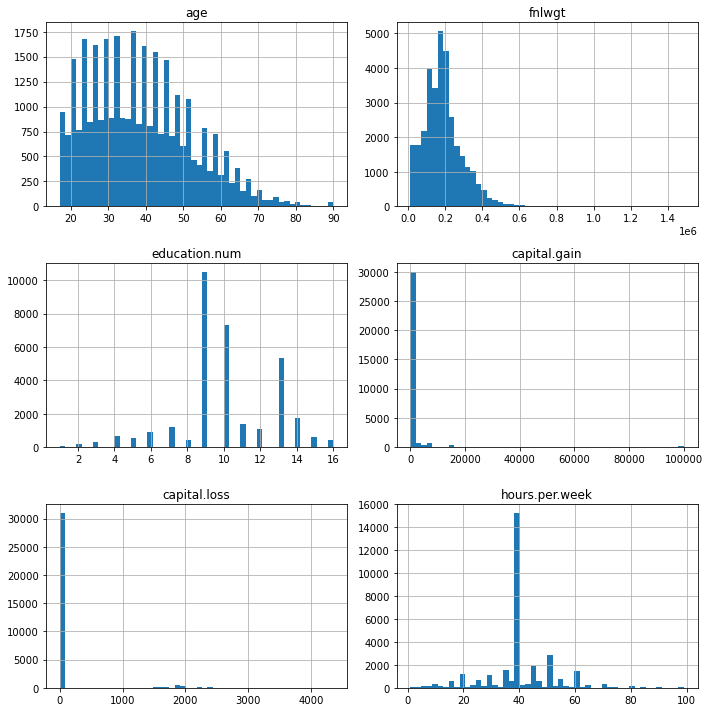

In [22]:
raw_data.hist(bins=50, figsize=(10, 10))
plt.tight_layout()
plt.show()

### `4.2` Check Im-balanced

  income        %
0  <=50K  0.75919
1   >50K  0.24081


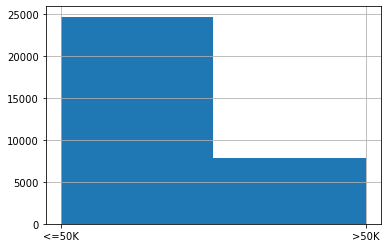

In [23]:
print(((raw_data.iloc[:, -1].value_counts())/raw_data.shape[0]).reset_index().rename(columns={'index': 'income', 'income': '%'}))
raw_data.iloc[:, -1].hist(bins=2)
plt.show()

## `4.3` Data-preprocessing without (scalling)

In [24]:
X_train_preprocessed_without_scale, X_val_preprocessed_without_scale = data_preprocessing(X_train, y_train, X_val, y_val, 
                                                                                          out_threshold=1.5, 
                                                                                          shapiro_threshold=0.01,
                                                                                          dup_threshold=.8 , scale=False)

shape = 26048, total matched 25926
shape = 26048, total matched 25289
shape = 26048, total matched 25092
shape = 26048, total matched 18818
shape = 6513, total matched 6492
shape = 6513, total matched 6292
shape = 6513, total matched 6271
shape = 6513, total matched 4735
*SK_coeff:             index   sk_coef
0             age  0.516330
1          fnlwgt  0.546748
2   education.num -0.027694
3  hours.per.week  0.440920


### `4.3.0` DecisionTree with default hyper-parameters

In [25]:
default_decision_model = create_decision_tree_model(X_train_preprocessed_without_scale, y_train, default=True)
evaluate_decision_tree_model(y_val, X_val_preprocessed_without_scale, default_decision_model)

,precision_le,precision_g,recall_le,recall_g,f1_score_le,f1_score_g
0,0.849279,0.537245,0.858038,0.51977,0.853636,0.528363


### `4.3.1` DecisionTree GridSearch to get best hyper-parameters

In [26]:
decision_trees_model = []
for d in ma_depth:
    for s_split in mi_s_split:
        for s_leaf in mi_s_leaf:
            for nfeatures in ma_features:
                for l_node in ma_l_nodes:
                    for a in cpp_alpha:
                        decision_trees_model.append(create_decision_tree_model(X_train_preprocessed_without_scale, y_train, d, s_split,
                                                                            s_leaf, nfeatures, l_node, a, default=False))
                        
decision_trees_metrics = evaluate_trees_models(y_val, X_val_preprocessed_without_scale, decision_trees_model)
decision_trees_metrics.sort_values(by=['f1_g'], ascending=False).head(5)

,depth,sample_split,sample_leaf,features,leaf_nodes,ccp_alpha,precision_le,recall_le,f1_le,precision_g,recall_g,f1_g
302,5,0.05,0.01,9,3,0.001,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
103,3,0.30,0.01,6,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
255,4,0.30,0.01,9,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
63,3,0.10,0.01,9,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
151,4,0.05,0.01,6,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212


## `4.4` Data-preprocessing with (handle skew, clamp-outliers, and scalling)

In [27]:
raw_data = pd.read_csv('adult.csv').drop(columns=['education'])

X_train, X_val, y_train, y_val = train_test_split(raw_data.iloc[:, :-1], raw_data.iloc[:, [-1]], test_size=0.2, stratify=raw_data.iloc[:, [-1]], random_state=2022)

shape = 26048, total matched 25926
shape = 26048, total matched 25289
shape = 26048, total matched 25092
shape = 26048, total matched 18818
shape = 6513, total matched 6492
shape = 6513, total matched 6292
shape = 6513, total matched 6271
shape = 6513, total matched 4735
*SK_coeff:             index   sk_coef
0             age  0.516330
1          fnlwgt  0.546748
2   education.num -0.027694
3  hours.per.week  0.440920
########################################################## Q-Q PLOT ##########################################################


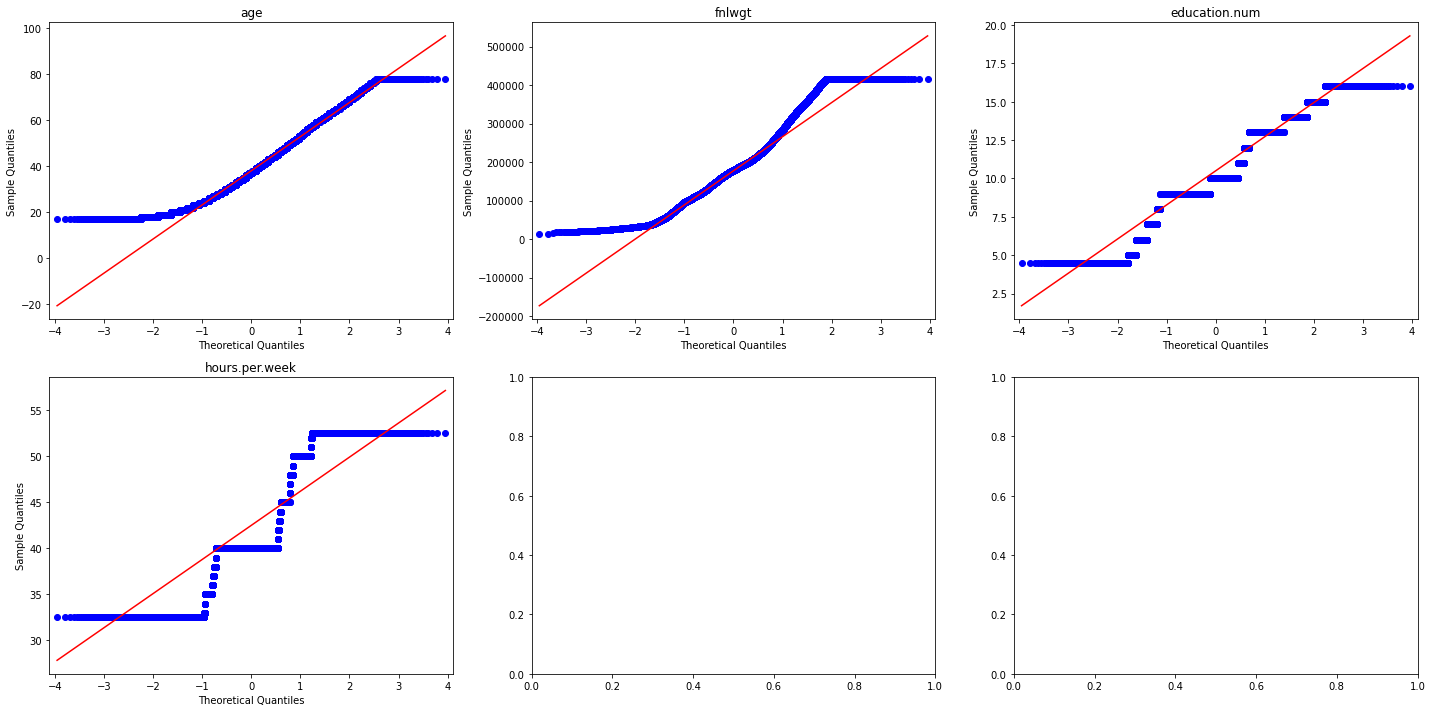

##############################################################################################################################
* W_Statistic=0.965, p=0.00000000
  age does not look Gaussian (reject H0)
* W_Statistic=0.965, p=0.00000000
  fnlwgt does not look Gaussian (reject H0)
* W_Statistic=0.925, p=0.00000000
  education.num does not look Gaussian (reject H0)
* W_Statistic=0.861, p=0.00000000
  hours.per.week does not look Gaussian (reject H0)
* Number of features needs min_max = 4, std = 0 according to shapiro-test.
* All features did not follow gaussian distribution according to shapiro-test, min-max scalling used.


In [28]:
X_train_preprocessed, X_val_preprocessed = data_preprocessing(X_train, y_train, X_val, y_val, 
                                                              out_threshold=1.5, 
                                                              shapiro_threshold=0.01,
                                                              dup_threshold=.8)

### `4.4.0` DecisionTree with default hyper-parameters

In [29]:
default_decision_model = create_decision_tree_model(X_train_preprocessed, y_train, default=True)
evaluate_decision_tree_model(y_val, X_val_preprocessed, default_decision_model)

,precision_le,precision_g,recall_le,recall_g,f1_score_le,f1_score_g
0,0.84976,0.537804,0.857836,0.521684,0.853779,0.529621


### `4.4.1` DecisionTree GridSearch to get best hyper-parameters

In [30]:
decision_trees_model = []
for d in ma_depth:
    for s_split in mi_s_split:
        for s_leaf in mi_s_leaf:
            for nfeatures in ma_features:
                for l_node in ma_l_nodes:
                    for a in cpp_alpha:
                        decision_trees_model.append(create_decision_tree_model(X_train_preprocessed, y_train, d, s_split,
                                                                            s_leaf, nfeatures, l_node, a, default=False))
                        
decision_trees_metrics = evaluate_trees_models(y_val, X_val_preprocessed, decision_trees_model)
decision_trees_metrics.sort_values(by=['f1_g'], ascending=False).head(5)

,depth,sample_split,sample_leaf,features,leaf_nodes,ccp_alpha,precision_le,recall_le,f1_le,precision_g,recall_g,f1_g
302,5,0.05,0.01,9,3,0.001,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
103,3,0.30,0.01,6,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
255,4,0.30,0.01,9,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
63,3,0.10,0.01,9,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212
151,4,0.05,0.01,6,3,0.010,0.939626,0.670374,0.782486,0.453936,0.864158,0.595212


### `4.4.2` Plot tree for the best DecisionTree

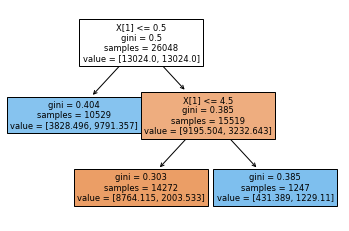

In [31]:
tree.plot_tree(decision_trees_model[302], filled=True);

## `4.5` Using RandomForestClassifier

In [32]:
n_estimators = [10, 50, 100]

In [33]:
random_forest_models = []
for d in ma_depth:
    for s_split in mi_s_split:
        for s_leaf in mi_s_leaf:
            for nfeatures in ma_features:
                for l_node in ma_l_nodes:
                    for a in cpp_alpha:
                        for n_estimator in n_estimators:
                            random_model = RandomForestClassifier(n_estimators=n_estimator, max_depth=d, min_samples_split=s_split,
                                                   min_samples_leaf=s_leaf, max_features=nfeatures, max_leaf_nodes=l_node, 
                                                   bootstrap=True, n_jobs=-1, random_state=2022, class_weight='balanced', ccp_alpha=a)
                            random_forest_models.append(random_model.fit(X_train_preprocessed, y_train))
                        
random_forest_metrics = evaluate_trees_models(y_val, X_val_preprocessed, random_forest_models, 'random')
random_forest_metrics.sort_values(by=['f1_g'], ascending=False).head(5)

,depth,sample_split,sample_leaf,features,leaf_nodes,ccp_alpha,precision_le,recall_le,f1_le,precision_g,recall_g,f1_g,n_estimators
726,4,0.3,0.01,3,3,0.001,0.923975,0.720121,0.80941,0.479504,0.813138,0.603265,10
297,3,0.3,0.01,3,3,0.010,0.923975,0.720121,0.80941,0.479504,0.813138,0.603265,10
294,3,0.3,0.01,3,3,0.001,0.923975,0.720121,0.80941,0.479504,0.813138,0.603265,10
1158,5,0.3,0.01,3,3,0.001,0.923975,0.720121,0.80941,0.479504,0.813138,0.603265,10
729,4,0.3,0.01,3,3,0.010,0.923975,0.720121,0.80941,0.479504,0.813138,0.603265,10


## `4.6` Using KNeighborsClassifier

In [34]:
# initialize our hyper-parameters lists
p_values = [1, 2, 3]
n_neighbors = [2, 3, 5, 6]
weights = ['uniform', 'distance']

In [35]:
# show each class percentage
print(f"* rare class ('>50K'): {(raw_data['income']=='>50K').mean().round(4)}")
print(f"* dominant class ('<=50K'): {(raw_data['income']=='<=50K').mean().round(4)}")

* rare class ('>50K'): 0.2408
* dominant class ('<=50K'): 0.7592


In [36]:
# spliting then undersampling
X_train, X_val, y_train, y_val = train_test_split(raw_data.iloc[:, :-1], raw_data.iloc[:, [-1]], 
                                                  test_size=0.2, stratify=raw_data.iloc[:, [-1]], random_state=2022)

rare_class = X_train.loc[(y_train=='>50K').values, :]
dominant_class = X_train.loc[(y_train=='<=50K').values, :]

under_sampled_class = dominant_class.sample(frac=0.35, replace=False, random_state=2022)
X_train_undersampled = pd.concat((under_sampled_class, rare_class), axis=0)
y_train_undersampled = y_train.loc[X_train_undersampled.index, :]
X_train_undersampled.shape, y_train_undersampled.shape

((13194, 13), (13194, 1))

shape = 13194, total matched 13140
shape = 13194, total matched 12809
shape = 13194, total matched 13114
shape = 13194, total matched 11389
shape = 6513, total matched 6488
shape = 6513, total matched 6282
shape = 6513, total matched 6479
shape = 6513, total matched 5517
*SK_coeff:             index   sk_coef
0             age  0.361842
1          fnlwgt  0.550586
2   education.num -0.258166
3  hours.per.week  0.436611
########################################################## Q-Q PLOT ##########################################################


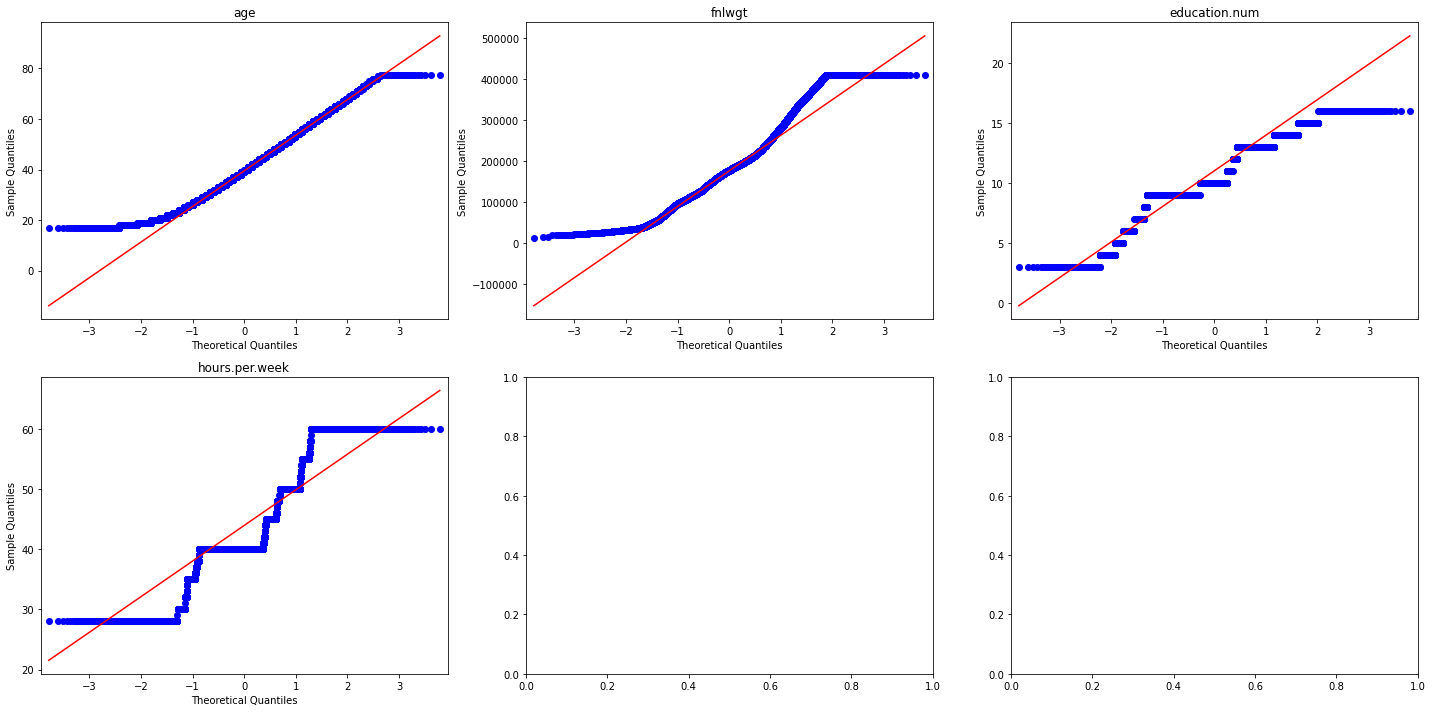

##############################################################################################################################
* W_Statistic=0.983, p=0.00000000
  age does not look Gaussian (reject H0)
* W_Statistic=0.967, p=0.00000000
  fnlwgt does not look Gaussian (reject H0)
* W_Statistic=0.925, p=0.00000000
  education.num does not look Gaussian (reject H0)
* W_Statistic=0.890, p=0.00000000
  hours.per.week does not look Gaussian (reject H0)
* Number of features needs min_max = 4, std = 0 according to shapiro-test.
* All features did not follow gaussian distribution according to shapiro-test, min-max scalling used.


In [37]:
# preprocessing for KNN
X_train_preprocessed, X_val_preprocessed = data_preprocessing(X_train_undersampled, y_train_undersampled, X_val, y_val, 
                                                              out_threshold=1.5, 
                                                              shapiro_threshold=0.01,
                                                              dup_threshold=.8)

In [38]:
knn_models = []
for p in p_values:
    for n in n_neighbors:
        for w in weights:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=w, p=p, metric='minkowski', n_jobs=-1)
            knn_models.append(knn_model.fit(X_train_preprocessed, y_train_undersampled))

knn_metrics = evaluate_knn_models(y_val, X_val_preprocessed, knn_models)
knn_metrics.sort_values(by=['f1_g'], ascending=False).head(5)

,p,n_neighbors,weight,precision_le,recall_le,f1_le,precision_g,recall_g,f1_g
6,1,6,uniform,0.911378,0.813145,0.859464,0.560209,0.750638,0.641592
14,2,6,uniform,0.907838,0.812740,0.857661,0.556088,0.739796,0.634921
4,1,5,uniform,0.925600,0.764813,0.837560,0.520808,0.806122,0.632791
22,3,6,uniform,0.906420,0.810920,0.856015,0.552417,0.735969,0.631118
12,2,5,uniform,0.926145,0.760768,0.835350,0.517340,0.808673,0.631003


# CONCLUSION
1. It is approximately no difference between scaled and non-scaled data
2. Using randomforest using (n_estimator) performs slightly better than decision trees.
3. Finally the KNN is the best model compared to Trees it outperform trees. 64% compared to 60% with randomforest (f1_score), recall got reduced while precision has increased.

| n_estimators |  depth  | sample_split | sample_leaf | num_features | leaf_nodes |  alpha  |  prec_g  | recall_g |   f1_g   |       Type      | Scale |
|:------------:|:-------:|:------------:|:-----------:|:------------:|:----------:|:-------:|:--------:|:--------:|:--------:|:---------------:|:-----:|
|      --      | default |    default   |   default   |    default   |   default  | default | 0.537245 |  0.51977 | 0.528363 |   DecisionTree  | False |
|      --      |    5    |     0.05     |     0.01    |       9      |      3     |  0.001  | 0.453936 | 0.864158 | 0.595212 | DT + GridSearch | False |
|      --      | default |    default   |   default   |    default   |   default  | default | 0.537804 | 0.521684 | 0.529621 |   DecisionTree  |  True |
|      --      |    5    |     0.05     |     0.01    |       9      |      3     |  0.001  | 0.453936 | 0.864158 | 0.595212 | DT + GridSearch |  True |
|      10      |    4    |      0.3     |     0.01    |       3      |      3     |  0.001  | 0.479504 | 0.813138 | 0.603265 | RF + GridSearch |  True |

| n_neighbors | p_value |  weight |  prec_g  | recall_g |   f1_g   | Type | Scale |
|:-----------:|:-------:|:-------:|:--------:|:--------:|:--------:|:----:|:-----:|
|      6      |    1    | uniform | 0.560209 | 0.750638 | 0.641592 |  KNN |  True |